# Multi-Agent Workflows + RAG - LangGraph

Today we'll be looking at an example of a Multi-Agent workflow that's powered by LangGraph, LCEL, and more!

We're going to be, more specifically, looking at a "heirarchical agent teams" from the [AutoGen: Enabling Next-Gen LLM
Applications via Multi-Agent Conversation](https://arxiv.org/pdf/2308.08155) paper.

This will be the final "graph" of our system:

![image](https://i.imgur.com/Bhc7RVE.png)

It's important to keep in mind that the actual implementation will be constructed of 3 separate graphs, the final one having 2 graphs as nodes! LangGraph is a heckuva tool!



# 🤝 BREAKOUT ROOM #1

## Dependencies

We'll start, as we normally do, by grabbing our dependencies.

We'll be using LangChain and LangGraph to power our application, so let's start by grabbing those!

In [1]:
#!pip install -qU langgraph==0.2.14 langchain==0.2.14 langchain_openai==0.1.23 langchain_core==0.2.35 langchain-community

We're going to be showing a simple RAG chain as part of our LangGraph - and so we'll need specific dependencies for that as well!

In [2]:
#!pip install -qU --disable-pip-version-check qdrant-client pymupdf tiktoken

Since we'll be relying on OpenAI's suite of models to power our agents today, we'll want to provide our OpenAI API Key.

We're also going to be using the Tavily search tool - so we'll want to provide that API key as well!

Instruction for how to obtain the Tavily API key can be found:

1. [Tavily API Key](https://app.tavily.com/sign-in)



In [50]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")
os.environ["TAVILY_API_KEY"] = getpass.getpass("TAVILY_API_KEY")

## Task 1: Simple LCEL RAG

Now that we have our dependencies set-up - let's create a simple RAG chain that works over a single PDF.

> NOTE: While this particular example is very straight forward - you can "plug in" any complexity of chain you desire as a node in a LangGraph.

## Retrieval

The 'R' in 'RAG' - this is, at this point, fairly straightforward!

#### Data Collection and Processing

A classic first step, at this point, let's grab our desired document!

In [51]:
from langchain.document_loaders import PyMuPDFLoader

docs = PyMuPDFLoader("https://arxiv.org/pdf/2404.19553").load()

Now we can chunk it down to size!

In [67]:
import tiktoken
from langchain.text_splitter import RecursiveCharacterTextSplitter

def tiktoken_len(text):
    tokens = tiktoken.encoding_for_model("gpt-4o-mini").encode(
        text,
    )
    return len(tokens)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 200,
    chunk_overlap = 0,
    length_function = tiktoken_len,
)

# split_chunks = text_splitter.split_documents(docs)

Now we've successfully split our single PDF into...

In [9]:
len(split_chunks)

23

documents!

#### Embedding Model and Vector Store

Now that we have our chunked document - lets create a vector store, which will first require us to create an embedding model to get the vector representations of our text!

We'll use OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) model - as it's cheap, and performant.

In [70]:
from langchain_openai.embeddings import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

Now we can create our QDrant backed vector store!

In [71]:
from langchain_community.vectorstores import Qdrant


qdrant_vectorstore = Qdrant.from_documents(
    split_chunks,
    embedding_model,
    location=":memory:",
    collection_name="extending_context_window_llama_3",
)

Let's make sure we can access it as a retriever.

In [72]:
qdrant_retriever = qdrant_vectorstore.as_retriever()

### Augmented

Now that we have our retrieval process set-up, we need to set up our "augmentation" process - AKA a prompt template.

In [73]:
from langchain_core.prompts import ChatPromptTemplate

RAG_PROMPT = """
CONTEXT:
{context}

QUERY:
{question}

You are a helpful assistant. Use the available context to answer the question. If you can't answer the question, say you don't know.
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

### Generation

Last, but certainly not least, let's put the 'G' in 'RAG' by adding our generator - in this case, we can rely on OpenAI's [`gpt-4o-mini`](https://platform.openai.com/docs/models/gpt-4o-mini) model!

In [74]:
from langchain_openai import ChatOpenAI

openai_chat_model = ChatOpenAI(model="gpt-4o-mini")

### RAG - Retrieval Augmented Generation

All that's left to do is combine our R, A, and G into a single chain - and we're off!

In [75]:
from operator import itemgetter
from langchain.schema.output_parser import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | qdrant_retriever, "question": itemgetter("question")}
    | rag_prompt | openai_chat_model | StrOutputParser()
)

Let's test this out and make sure it works.

In [16]:
rag_chain.invoke({"question" : "What does the 'context' in 'long context' refer to?"})

'In the context of "long context" referring to large language models (LLMs), "context" refers to the amount of text or information that the model can process or consider at one time. Specifically, it encompasses the length of input data that the model can analyze, which can include books, papers, or other extensive written materials. In the provided document, the term is associated with extending the context length of the Llama-3-8B-Instruct model from 8,000 tokens to 80,000 tokens, allowing the model to handle much larger segments of text for tasks such as question-answering and information aggregation.'

### RAG Limitation

Notice how we're hard-coding our data, while this is simply meant to be an illustrative example - you could easily extend this to work with any provied paper or document in order to have a more dynamic system.

For now, we'll stick with this single hard-coded example in order to keep complexity down in an already very long notebook!

##### 🏗️ Activity #1 (Bonus Marks)

Allow the system to dynamically fetch Arxiv papers instead of hard coding them.

> HINT: Tuesday's assignment will be very useful here.

In [165]:
import urllib.request
import urllib.parse
import xml.etree.ElementTree as ET
from typing import Annotated
from langchain_core.tools import tool

@tool
def get_arxiv_pdf_url(
    title: Annotated[str, "Title of the paper to search on arXiv"]
) -> Annotated[str, "Found paper title and direct URL to the PDF, or an error message if not found"]:
    """
    Searches arXiv for a paper by title, extracts the arXiv ID and actual paper title,
    and returns the paper title along with the direct PDF URL. Returns an error message if not found.
    """
    try:
        query = f'ti:"{title}"'
        encoded_query = urllib.parse.quote_plus(query)
        api_url = f"http://export.arxiv.org/api/query?search_query={encoded_query}&start=0&max_results=1"
        with urllib.request.urlopen(api_url) as response:
            data = response.read()
        root = ET.fromstring(data)
        ns = {'atom': 'http://www.w3.org/2005/Atom'}
        entry = root.find('atom:entry', ns)
        if entry is None:
            return f"No matching paper found for title: {title}"
        title_elem = entry.find('atom:title', ns)
        found_title = title_elem.text.strip() if title_elem is not None else "Unknown Title"
        id_elem = entry.find('atom:id', ns)
        if id_elem is None or not id_elem.text:
            return f"No arXiv ID found for title: {title}"
        arxiv_id = id_elem.text.rsplit('/', 1)[-1]
        pdf_url = f"https://arxiv.org/pdf/{arxiv_id}.pdf"
        return pdf_url
    except Exception as e:
        return f"An error occurred while searching arXiv: {e}"


In [167]:
url = get_arxiv_pdf_url.invoke({"title": "Attention is all you need"})
print(url)

https://arxiv.org/pdf/1706.03762v7.pdf


In [128]:
from langchain.document_loaders import PyMuPDFLoader

docs = PyMuPDFLoader(url).load()

In [129]:
docs

[Document(metadata={'source': 'https://arxiv.org/pdf/1706.03762v7.pdf', 'file_path': 'https://arxiv.org/pdf/1706.03762v7.pdf', 'page': 0, 'total_pages': 15, 'format': 'PDF 1.5', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'creator': 'LaTeX with hyperref', 'producer': 'pdfTeX-1.40.25', 'creationDate': 'D:20240410211143Z', 'modDate': 'D:20240410211143Z', 'trapped': ''}, page_content='Provided proper attribution is provided, Google hereby grants permission to\nreproduce the tables and figures in this paper solely for use in journalistic or\nscholarly works.\nAttention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.com\nNoam Shazeer∗\nGoogle Brain\nnoam@google.com\nNiki Parmar∗\nGoogle Research\nnikip@google.com\nJakob Uszkoreit∗\nGoogle Research\nusz@google.com\nLlion Jones∗\nGoogle Research\nllion@google.com\nAidan N. Gomez∗†\nUniversity of Toronto\naidan@cs.toronto.edu\nŁukasz Kaiser∗\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin∗‡\nillia.polosu

In [130]:
split_chunks = text_splitter.split_documents(docs)
len(split_chunks)

62

In [131]:
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_community.vectorstores import Qdrant
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from operator import itemgetter
from langchain.schema.output_parser import StrOutputParser

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

qdrant_vectorstore = Qdrant.from_documents(
    split_chunks,
    embedding_model,
    location=":memory:",
    collection_name="dynamic_arxiv_rag",
)

qdrant_retriever = qdrant_vectorstore.as_retriever()


RAG_PROMPT = """
CONTEXT:
{context}

QUERY:
{question}

You are a helpful assistant. Use the available context to answer the question. If you can't answer the question, say you don't know.
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

openai_chat_model = ChatOpenAI(model="gpt-4o-mini")

rag_chain = (
    {"context": itemgetter("question") | qdrant_retriever, "question": itemgetter("question")}
    | rag_prompt | openai_chat_model | StrOutputParser()
)

In [132]:
rag_chain.invoke({"question" : "What does the 'context' in 'long context' refer to?"})

"The 'context' in 'long context' refers to the length of the input sequences processed by models, particularly in the realm of natural language processing (NLP). It involves the amount of information or the number of tokens (words or symbols) that the model can consider when generating outputs or making predictions. In the provided excerpts, there are mentions of self-attention mechanisms and computational performance regarding long sequences, indicating that 'long context' pertains to handling extensive textual data effectively, which is often necessary for understanding complex relationships within sentences or paragraphs."

In [133]:
rag_chain.invoke({"question" : "Who is Batman?"})

"I don't know."

## Task 2: Helper Functions for Agent Graphs

We'll be using a number of agents, nodes, and supervisors in the rest of the notebook - and so it will help to have a collection of useful helper functions that we can leverage to make our lives easier going forward.

Let's start with the most simple one!

#### Import Wall

Here's a wall of imports we'll be needing going forward!

In [134]:
from typing import Any, Callable, List, Optional, TypedDict, Union

from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.runnables import Runnable
from langchain_core.tools import BaseTool
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph

### Agent Node Helper

Since we're going to be wrapping each of our agents into a node - it will help to have an easy way to create the node!

In [135]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

### Agent Creation Helper Function

Since we know we'll need to create agents to populate our agent nodes, let's use a helper function for that as well!

Notice a few things:

1. We have a standard suffix to append to our system messages for each agent to handle the tool calling and boilerplate prompting.
2. Each agent has its our scratchpad.
3. We're relying on OpenAI's function-calling API for tool selection
4. Each agent is its own executor.

In [136]:
def create_agent(
    llm: ChatOpenAI,
    tools: list,
    system_prompt: str,
) -> str:
    """Create a function-calling agent and add it to the graph."""
    system_prompt += ("\nWork autonomously according to your specialty, using the tools available to you."
    " Do not ask for clarification."
    " Your other team members (and other teams) will collaborate with you with their own specialties."
    " You are chosen for a reason! You are one of the following team members: {team_members}.")
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

### Supervisor Helper Function

Finally, we need a "supervisor" that decides and routes tasks to specific agents.

Since each "team" will have a collection of potential agents - this "supervisor" will act as an "intelligent" router to make sure that the right agent is selected for the right task.

Notice that, at the end of the day, this "supervisor" is simply directing who acts next - or if the state is considered "done".

In [137]:
def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

## Task 3: Research Team - A LangGraph for Researching A Specific Topic

Now that we have our RAG chain set-up and some awesome helper functions, we want to create a LangGraph related to researching a specific topic.

We're going to start by equipping our Research Team with a few tools:

1. Tavily Search - aka "Google", for the most up to date information possible.
2. Our RAG chain - specific and high quality information about our topic.

Let's create those tools now!

### Tool Creation

As you can see below, some tools already come pre-packaged ready to use!

In [138]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

Creating a custom tool, however, is very straightforward.

> NOTE: You *must* include a docstring, as that is what the LLM will consider when deciding when to use this tool.

In [203]:
from typing import Annotated, Optional
from langchain_core.tools import tool
from langchain.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Qdrant
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain.schema.output_parser import StrOutputParser
from operator import itemgetter
import tiktoken

def tiktoken_len(text):
    tokens = tiktoken.encoding_for_model("gpt-4o-mini").encode(text)
    return len(tokens)

@tool
def create_rag_chain_from_paper(
    paper_name: Annotated[str, "Name or title of the Arxiv paper to process"],
    chunk_size: Annotated[int, "Size of text chunks for splitting"] = 200,
    chunk_overlap: Annotated[int, "Overlap between chunks"] = 0,
    collection_name: Annotated[Optional[str], "Name for the Qdrant collection"] = None
):
    """
    Create a RAG chain from an Arxiv paper by:
    1. Getting the paper's PDF URL
    2. Loading the PDF
    3. Splitting into chunks
    4. Creating embeddings
    5. Setting up Qdrant vector store
    6. Creating a RAG chain
    
    Returns a dictionary containing the RAG chain and retriever for use in agent nodes.
    """
    # Get the PDF URL using the existing tool
    pdf_url = get_arxiv_pdf_url(paper_name)
    
    # Load the PDF document
    docs = PyMuPDFLoader(pdf_url).load()
    
    # Split the document into chunks
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=tiktoken_len,
    )
    split_chunks = text_splitter.split_documents(docs)
    
    # Create vector store
    qdrant_vectorstore = Qdrant.from_documents(
        split_chunks,
        embedding_model,
        location=":memory:",
        collection_name=collection_name or f"arxiv_paper_{paper_name[:20]}",
    )
    qdrant_retriever = qdrant_vectorstore.as_retriever()
    
    # Create RAG prompt template
    RAG_PROMPT = """
    CONTEXT:
    {context}

    QUERY:
    {question}

    You are a helpful assistant. Use the available context to answer the question. 
    If you can't answer the question, say you don't know.
    """
    rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)
    
    # Create RAG chain
    rag_chain = (
        {"context": itemgetter("question") | qdrant_retriever, "question": itemgetter("question")}
        | rag_prompt | openai_chat_model | StrOutputParser()
    )
    
    return {
        "rag_chain": rag_chain,
        "retriever": qdrant_retriever,
        "vectorstore": qdrant_vectorstore
    }

In [208]:
# Create RAG chain for a specific paper
result = create_rag_chain_from_paper.invoke({
    "paper_name":"Latent Dirichlet Allocation",
    "chunk_size":200,
    "chunk_overlap":0
})

# Use the RAG chain
answer = result["rag_chain"].invoke({"question": "What are the main findings?"})

In [ ]:
# from typing import Annotated, List, Tuple, Union
# from langchain_core.tools import tool

# @tool
# def retrieve_information(
#     query: Annotated[str, "query to ask the retrieve information tool"]
#     ):
#   """Use Retrieval Augmented Generation to retrieve information about the 'Extending Llama-3’s Context Ten-Fold Overnight' paper."""
#   return rag_chain.invoke({"question" : query})

In [209]:
answer

'The main findings from the context provided indicate that the results of segmentation using different methods (PM-LDA, FCM, and LDA) were qualitatively analyzed because of the lack of ground-truth data. Specifically, the segmentation results for various images were presented in Figure 4, highlighting the partial membership maps for different topics using PM-LDA and the clusters using FCM. The color in the maps indicates the degree of membership of a visual word in a topic. Overall, the findings suggest a comparative evaluation of segmentation methods based on visual representation.'

> NOTE: We could just as easily use the LCEL chain directly, since nodes can be LCEL objects - but creating a tool helps explain the tool creation process at the same time.

### Research Team State

Since we're using LangGraph - we're going to need state!

Let's look at how we've created our state below.

In [210]:
import functools
import operator

from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
import functools

class ResearchTeamState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: List[str]
    next: str

Notice how we've used `messages`, `team_members`, and `next`.

These states will help us understand:

1. What we've done so far (`messages`)
2. Which team members we have access to (`team_members`)
3. Which team member is up next! (`next`)

### Research Team LLM

We'll be using `gpt-4o-mini` today. This LLM is going to be doing a lot of reasoning - but we also want to keep our costs down, so we'll use a lightweight; but powerful, model!

In [211]:
llm = ChatOpenAI(model="gpt-4o-mini")

##### ❓ Question #1:

Why is a "powerful" LLM important for this use-case?

What tasks must our Agent perform that make it such that the LLM's reasoning capability is a potential limiter?

A powerful LLM is ideal for this multi-agent system due to the critical nature of the following tasks:
1. Complex decision making - supervisor needs to decvide which team member or tool to use based on the state and requirements
2. Tool selection and Usage - each agent must understand the capabilities and limitations of their tools
3. Context management - to keep track of the conversation and understand the current state of the task
4. Quality Control - verifying technical accuracy and tone and style in content creation
5. Coordination - Multi-agent systems are complex and the supervisors need to manage the flow of information while understanding the dependencies in order to produce a final output that meets all requirements.



### Research Team Agents & Nodes

Now we can use our helper functions to create our agent nodes, with their related tools.

Let's start with our search agent node.

#### Research Team: Search Agent

We're going to give our agent access to the Tavily tool, power it with our GPT-4o Mini model, and then create its node - and name it `Search`.

In [214]:
search_agent = create_agent(
    llm,
    [tavily_tool],
    "You are a research assistant who can search for up-to-date info using the tavily search engine.",
)
search_node = functools.partial(agent_node, agent=search_agent, name="Search")

#### Research Team: RAG Agent Node

Now we can wrap our LCEL RAG pipeline in an agent node as well, using the LCEL RAG pipeline as the tool, as created above.

In [228]:
research_agent = create_agent(
    llm,
    [create_rag_chain_from_paper],
    "You are a research assistant who can provide specific information on any requested paper from Arxiv. You must only respond with information about the paper related to the request.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="PaperInformationRetriever")

### Research Team Supervisor Agent

Notice that we're not yet creating our supervisor *node*, simply the agent here.

Also notice how we need to provide a few extra pieces of information - including which tools we're using.

> NOTE: It's important to use the *exact* tool name, as that is how the LLM will reference the tool. Also, it's important that your tool name is all a single alphanumeric string!



In [237]:
supervisor_agent = create_team_supervisor(
    llm,
    ("You are a supervisor tasked with managing a conversation between the"
    " following workers:  Search, PaperInformationRetriever. Given the following user request,"
    " determine the subject to be researched and respond with the worker to act next. "
    " you MUST use BOTH workers in sequence:"
    " 1. First use Search to find general information about the topic"
    " 2. Then use PaperInformationRetriever to get specific information from the paper"
    "Each worker will perform a task and respond with their results and status. "
    " When using PaperInformationRetriever, make sure to include both the query and the paper title."
    " You should never ask your team to do anything beyond research. They are not required to write content or posts."
    " You should only pass tasks to workers that are specifically research focused."
    " When finished, respond with FINISH."),
    ["Search", "PaperInformationRetriever"],
)

### Research Team Graph Creation

Now that we have our research team agent nodes created, and our supervisor agent - let's finally construct our graph!

We'll start by creating our base graph from our state, and then adding the nodes/agent we've created as nodes on our LangGraph.

In [238]:
research_graph = StateGraph(ResearchTeamState)

research_graph.add_node("Search", search_node)
research_graph.add_node("PaperInformationRetriever", research_node)
research_graph.add_node("supervisor", supervisor_agent)

Now we can define our edges - include our conditional edge from our supervisor to our agent nodes.

Notice how we're always routing our agent nodes back to our supervisor!

In [239]:
research_graph.add_edge("Search", "supervisor")
research_graph.add_edge("PaperInformationRetriever", "supervisor")
research_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"Search": "Search", "PaperInformationRetriever": "PaperInformationRetriever", "FINISH": END},
)

Now we can set our supervisor node as the entry point, and compile our graph!

In [240]:
research_graph.set_entry_point("supervisor")
compiled_research_graph = research_graph.compile()

In [241]:
compiled_research_graph

CompiledStateGraph(nodes={'__start__': PregelNode(config={'tags': ['langsmith:hidden'], 'metadata': {}, 'configurable': {}}, channels=['__start__'], triggers=['__start__'], writers=[ChannelWrite<messages,team_members,next>(recurse=True, writes=[ChannelWriteEntry(channel='messages', value=<object object at 0x148f1d900>, skip_none=False, mapper=_get_state_key(recurse=False)), ChannelWriteEntry(channel='team_members', value=<object object at 0x148f1d900>, skip_none=False, mapper=_get_state_key(recurse=False)), ChannelWriteEntry(channel='next', value=<object object at 0x148f1d900>, skip_none=False, mapper=_get_state_key(recurse=False))], require_at_least_one_of=['messages', 'team_members', 'next']), ChannelWrite<start:supervisor>(recurse=True, writes=[ChannelWriteEntry(channel='start:supervisor', value='__start__', skip_none=False, mapper=None)], require_at_least_one_of=None)]), 'Search': PregelNode(config={'tags': [], 'metadata': {}, 'configurable': {}}, channels={'messages': 'messages', 

#### Display Graph

In [242]:
import nest_asyncio
nest_asyncio.apply()

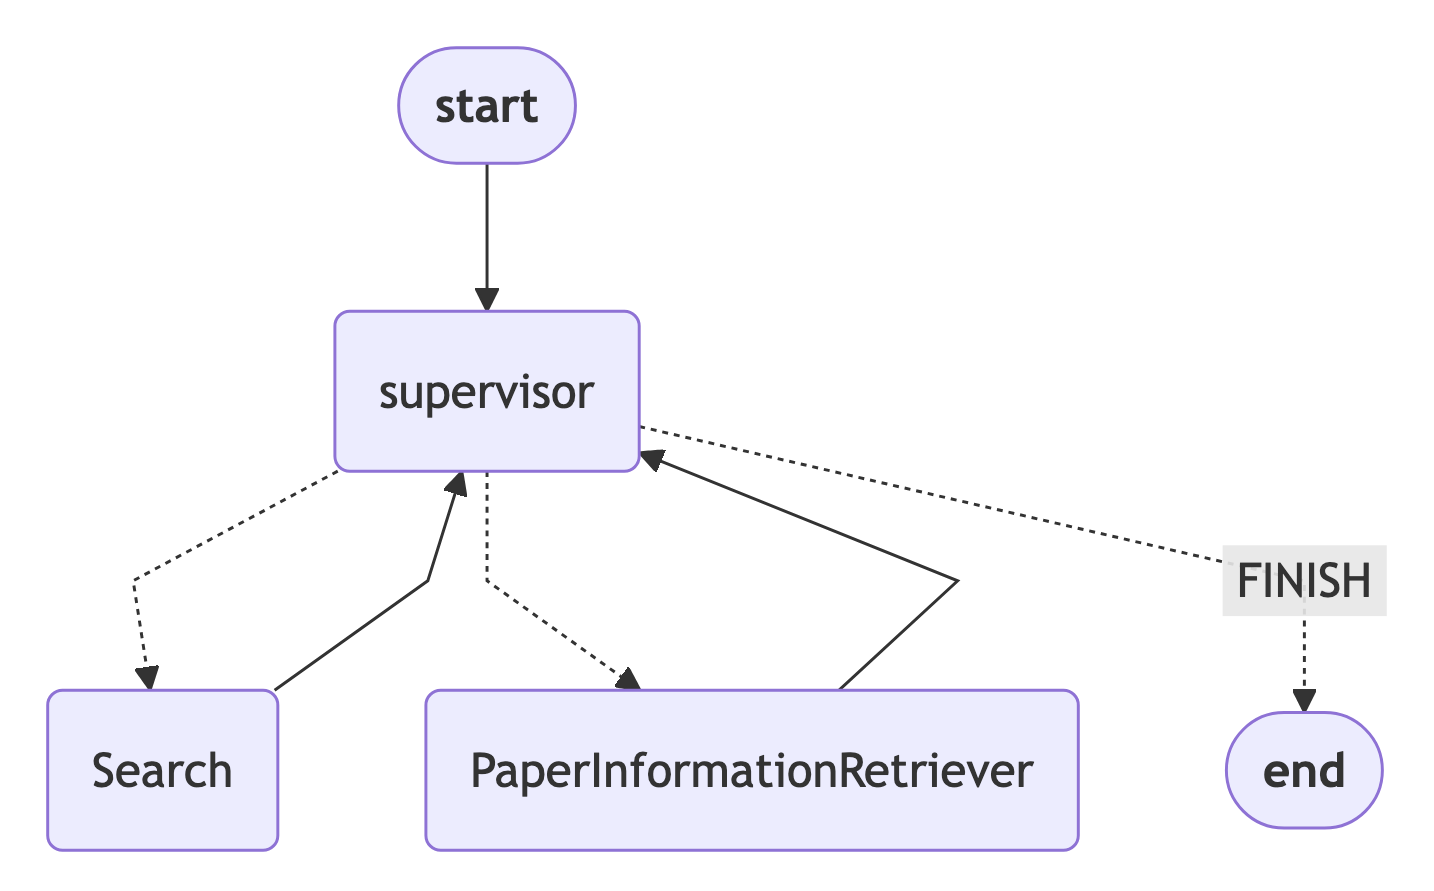

In [243]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        compiled_research_graph.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.LINEAR,
            node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
            wrap_label_n_words=9,
            output_file_path=None,
            draw_method=MermaidDrawMethod.PYPPETEER,
            background_color="white",
            padding=10,
        )
    )
)

The next part is key - since we need to "wrap" our LangGraph in order for it to be compatible in the following steps - let's create an LCEL chain out of it!

This allows us to "broadcast" messages down to our Research Team LangGraph!

In [244]:
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results

research_chain = enter_chain | compiled_research_graph

Now, finally, we can take it for a spin!

In [245]:
for s in research_chain.stream(
    "What are the main takeaways from the paper `Latent Dirichlet Allocation'? Please use Search and PaperInformationRetriever!", {"recursion_limit": 100}
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'Search'}}
---
{'Search': {'messages': [HumanMessage(content='The paper "Latent Dirichlet Allocation" by Blei, Ng, and Jordan presents a generative probabilistic model designed for analyzing collections of discrete data such as text corpora. Here are the main takeaways from the paper:\n\n1. **Model Overview**: Latent Dirichlet Allocation (LDA) is introduced as a three-level hierarchical Bayesian model. It models each document as a mixture of topics, where each topic is characterized by a distribution over words.\n\n2. **Generative Process**: LDA assumes a specific generative process for documents in a corpus. For each document:\n   - The number of words is drawn from a Poisson distribution.\n   - A topic distribution is selected from a Dirichlet distribution.\n   - For each word in the document, a topic is chosen from the multinomial distribution based on the topic distribution.\n\n3. **Inference and Parameter Estimation**: The paper discusses methods for infere

##### 🏗️ Activity #2:

Using whatever drawing application you wish - please label the flow above on a diagram of your graph.


![Flow_Diagram.png](attachment:Flow_Diagram.jpng)

##### ❓ Question #2:

How could you make sure your Agent uses specific tools that you wish it to use? Are there any ways to concretely set a flow through tools?
1. Using prompt engineering, you could instruct the supervisor to use the tool you would like it to use
2. In agent states, you could use conditional edges to program in the tools that you would liuke to be used
3. The tools could also be explicitly ordered in the flow to follow a certain order

# 🤝 BREAKOUT ROOM #2

## Task 4: Document Writing Team - A LangGraph for Writing, Editing, and Planning a LinkedIn post.

Let's run it all back, this time specifically creating tools, agent nodes, and a graph for planning, writing, and editing a LinkedIn post!

### Tool Creation

Let's create some tools that will help us understand, open, work with, and edit documents to our liking!

In [246]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional
from typing_extensions import TypedDict
import uuid
import os

os.makedirs('./content/data', exist_ok=True)

def create_random_subdirectory():
    random_id = str(uuid.uuid4())[:8]  # Use first 8 characters of a UUID
    subdirectory_path = os.path.join('./content/data', random_id)
    os.makedirs(subdirectory_path, exist_ok=True)
    return subdirectory_path

WORKING_DIRECTORY = Path(create_random_subdirectory())

@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to save the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ] = {},
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"

##### 🏗️ Activity #3:

Describe, briefly, what each of these tools is doing in your own words.

create_outline - Creates an outline from a list of points and saves it as a file	
read_document - Reads content from a document between optional start and end lines
write_document - Writes given text content to a document	edit_document - Inserts lines into specific positions in an existing document


### Document Writing State

Just like with our Research Team state - we want to keep track of a few things, however this time - we also want to keep track of which files we've created - so let's add that here!

In [247]:
import operator
from pathlib import Path

class DocWritingState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: str
    next: str
    current_files: str

### Document Writing Prelude Function

Since we have a working directory - we want to be clear about what our current working directory looks like - this helper function will allow us to do that cleanly!

In [248]:
def prelude(state):
    written_files = []
    if not WORKING_DIRECTORY.exists():
        WORKING_DIRECTORY.mkdir()
    try:
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
        ]
    except:
        pass
    if not written_files:
        return {**state, "current_files": "No files written."}
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }

### Document Writing Node Creation



In [249]:
doc_writer_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    ("You are an expert writing technical LinkedIn posts.\n"
    "Below are files currently in your directory:\n{current_files}"),
)
context_aware_doc_writer_agent = prelude | doc_writer_agent
doc_writing_node = functools.partial(
    agent_node, agent=context_aware_doc_writer_agent, name="DocWriter"
)

note_taking_agent = create_agent(
    llm,
    [create_outline, read_document],
    ("You are an expert senior researcher tasked with writing a LinkedIn post outline and"
    " taking notes to craft a LinkedIn post.\n{current_files}"),
)
context_aware_note_taking_agent = prelude | note_taking_agent
note_taking_node = functools.partial(
    agent_node, agent=context_aware_note_taking_agent, name="NoteTaker"
)

copy_editor_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    ("You are an expert copy editor who focuses on fixing grammar, spelling, and tone issues\n"
    "Below are files currently in your directory:\n{current_files}"),
)
context_aware_copy_editor_agent = prelude | copy_editor_agent
copy_editing_node = functools.partial(
    agent_node, agent=context_aware_copy_editor_agent, name="CopyEditor"
)

dopeness_editor_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    ("You are an expert in dopeness, litness, coolness, etc - you edit the document to make sure it's dope. Make sure to use a number of emojis."
    "Below are files currently in your directory:\n{current_files}"),
)
context_aware_dopeness_editor_agent = prelude | dopeness_editor_agent
dopeness_node = functools.partial(
    agent_node, agent=context_aware_dopeness_editor_agent, name="DopenessEditor"
)

doc_writing_supervisor = create_team_supervisor(
    llm,
    ("You are a supervisor tasked with managing a conversation between the"
    " following workers: {team_members}. You should always verify the technical"
    " contents after any edits are made. "
    "Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When each team is finished,"
    " you must respond with FINISH."),
    ["DocWriter", "NoteTaker", "DopenessEditor", "CopyEditor"],
)

### Document Writing Team LangGraph Construction

This part is almost exactly the same (with a few extra nodes) as our Research Team LangGraph construction - so we'll leave it as one block!

In [250]:
authoring_graph = StateGraph(DocWritingState)
authoring_graph.add_node("DocWriter", doc_writing_node)
authoring_graph.add_node("NoteTaker", note_taking_node)
authoring_graph.add_node("CopyEditor", copy_editing_node)
authoring_graph.add_node("DopenessEditor", dopeness_node)
authoring_graph.add_node("supervisor", doc_writing_supervisor)

authoring_graph.add_edge("DocWriter", "supervisor")
authoring_graph.add_edge("NoteTaker", "supervisor")
authoring_graph.add_edge("CopyEditor", "supervisor")
authoring_graph.add_edge("DopenessEditor", "supervisor")

authoring_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "DocWriter": "DocWriter",
        "NoteTaker": "NoteTaker",
        "CopyEditor" : "CopyEditor",
        "DopenessEditor" : "DopenessEditor",
        "FINISH": END,
    },
)

authoring_graph.set_entry_point("supervisor")
compiled_authoring_graph = authoring_graph.compile()

#### Display Graph

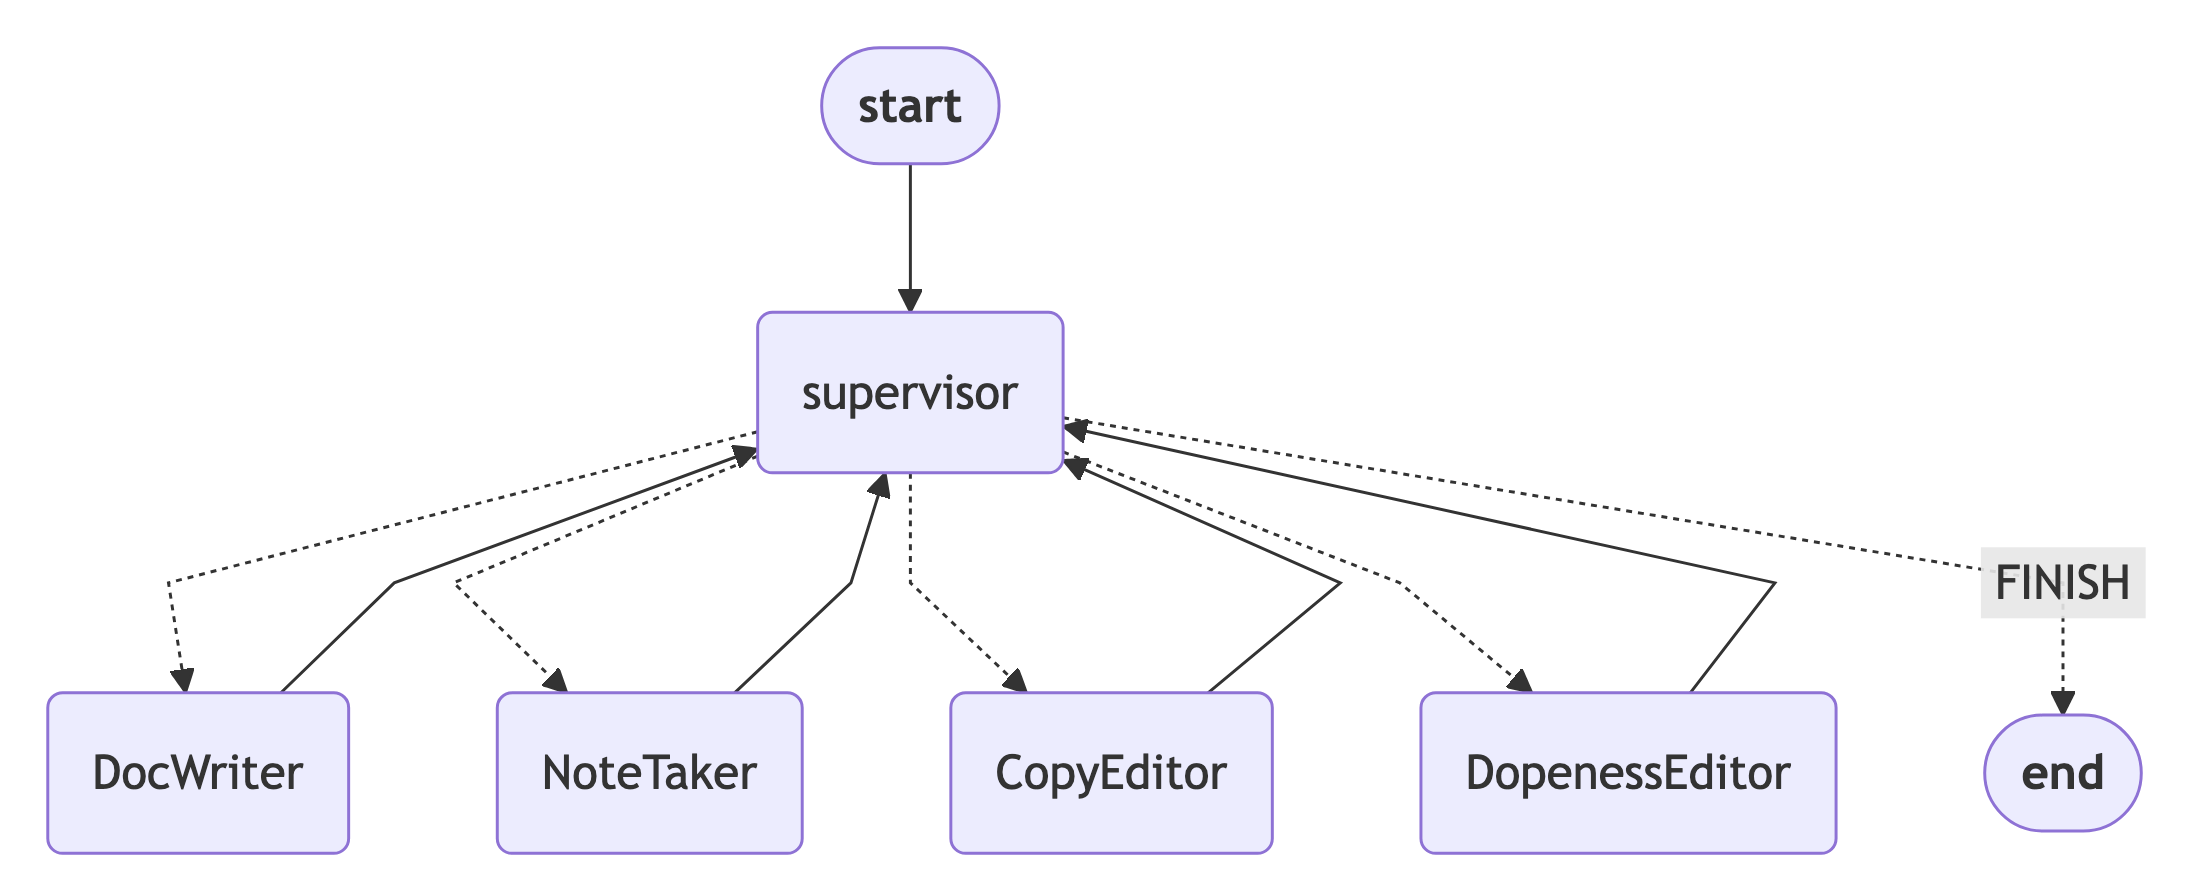

In [251]:
from IPython.display import Image, display

display(
    Image(
        compiled_authoring_graph.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.LINEAR,
            node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
            wrap_label_n_words=9,
            output_file_path=None,
            draw_method=MermaidDrawMethod.PYPPETEER,
            background_color="white",
            padding=10,
        )
    )
)

Just as before - we'll need to create an "interface" between the level above, and our graph.

In [252]:
def enter_chain(message: str, members: List[str]):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(members),
    }
    return results

authoring_chain = (
    functools.partial(enter_chain, members=authoring_graph.nodes)
    | authoring_graph.compile()
)

Now we can test this out!

> NOTE: It is possible you may see an error here - rerun the cell to clear.

In [253]:
for s in authoring_chain.stream(
    "Write an outline for for a short LinkedIn post on Linear Regression and write it to disk.",
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'DocWriter'}}
---
{'DocWriter': {'messages': [HumanMessage(content='The outline for a LinkedIn post on Linear Regression has been successfully created and saved to disk. If you need any further assistance or additional content, feel free to ask!', name='DocWriter')]}}
---
{'supervisor': {'next': 'NoteTaker'}}
---
{'NoteTaker': {'messages': [HumanMessage(content='The outline for the LinkedIn post on Linear Regression has been successfully created and saved. If you need any additional content or further assistance, feel free to ask!', name='NoteTaker')]}}
---
{'supervisor': {'next': 'CopyEditor'}}
---
{'CopyEditor': {'messages': [HumanMessage(content='The outline for the LinkedIn post on Linear Regression has been successfully created and saved to disk. If you need any further assistance or additional content, feel free to ask!', name='CopyEditor')]}}
---
{'supervisor': {'next': 'DopenessEditor'}}
---
{'DopenessEditor': {'messages': [HumanMessage(content='The outl

## Task 5: Meta-Supervisor and Full Graph

Finally, now that we have our two LangGraph agents (some of which are already multi-agent), we can build a supervisor that sits above all of them!

The final process, surprisingly, is quite straight forward!

Let's jump in!

First off - we'll need to create our supervisor agent node.

In [254]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

supervisor_node = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following teams: {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When all workers are finished,"
    " you must respond with FINISH.",
    ["Research team", "LinkedIn team"],
)

We'll also create our new state - as well as some methods to help us navigate the new state and the subgraphs.

> NOTE: We only pass the most recent message from the parent graph to the subgraph, and we only extract the most recent message from the subgraph to include in the state of the parent graph.

In [255]:
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    next: str

def get_last_message(state: State) -> str:
    return state["messages"][-1].content

def join_graph(response: dict):
    return {"messages": [response["messages"][-1]]}

Next, we'll create our base graph.

Notice how each node we're adding is *AN ENTIRE LANGGRAPH AGENT* (wrapped into an LCEL chain with our helper functions above).

In [256]:
super_graph = StateGraph(State)

super_graph.add_node("Research team", get_last_message | research_chain | join_graph)
super_graph.add_node(
    "LinkedIn team", get_last_message | authoring_chain | join_graph
)
super_graph.add_node("supervisor", supervisor_node)

Next, we'll create our edges!

This process is completely idenctical to what we've seen before - just addressing the LangGraph subgraph nodes instead of individual nodes.

In [257]:
super_graph.add_edge("Research team", "supervisor")
super_graph.add_edge("LinkedIn team", "supervisor")
super_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "LinkedIn team": "LinkedIn team",
        "Research team": "Research team",
        "FINISH": END,
    },
)
super_graph.set_entry_point("supervisor")
compiled_super_graph = super_graph.compile()

That's it!

Now we can finally use our full agent!

In [258]:
WORKING_DIRECTORY = Path(create_random_subdirectory())

for s in compiled_super_graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Write a LinkedIn post on the paper 'Supervised Topic Models'. First consult the research team. Then make sure you consult the LinkedIn team, and check for copy editing and dopeness, and write the file to disk."
            )
        ],
    },
    {"recursion_limit": 30},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'Research team'}}
---
{'Research team': {'messages': [HumanMessage(content='🚀 Exciting Research Alert! 🚀\n\nI’m thrilled to share insights from the groundbreaking paper titled **"Supervised Topic Models"** by David M. Blei and Jon D. McAuliffe. This research introduces the **supervised latent Dirichlet allocation (sLDA)**, a powerful statistical model designed for analyzing labeled documents.\n\nIn an era where we face an overwhelming amount of text data, understanding underlying themes is crucial. sLDA allows us to predict various response types based on the content of documents. It employs a maximum-likelihood approach for parameter estimation and showcases its versatility through real-world applications—such as predicting movie ratings from reviews!\n\nThe implications of this model stretch across industries, enhancing our ability to glean insights from text and improving decision-making processes. \n\nFor anyone interested in the intersection of machine lear

\n\n---\n\n🚀 **Exciting Research Alert!** 🚀\n\nI’m thrilled to share insights from the groundbreaking paper titled **"Supervised Topic Models"** by David M. Blei and Jon D. McAuliffe. This research introduces the **supervised latent Dirichlet allocation (sLDA)**, a powerful statistical model designed for analyzing labeled documents.\n\nIn an era where we face an overwhelming amount of text data, understanding underlying themes is crucial. sLDA allows us to predict various response types based on the content of documents. It employs a maximum-likelihood approach for parameter estimation and showcases its versatility through real-world applications—such as predicting movie ratings from reviews! 🎬✨\n\nThe implications of this model stretch across industries, enhancing our ability to glean insights from text and improving decision-making processes. 📊💡 \n\nFor anyone interested in the intersection of machine learning and natural language processing, this paper is a must-read! Dive into the details [here](https://www.sciencedirect.com/science/article/pii/S0925231214010054). 🧠🔍\n\n#MachineLearning #NaturalLanguageProcessing #Research #DataScience #SupervisedLearning\n\n---\n\n💥 The document has been saved as **"Supervised_Topic_Models_Research_Alert_Lit.txt"**. If you need more edits or fresh content, just holler! 😎✌️

## SAMPLE POST!

🚀 Exciting News in AI Research! 🚀

We're thrilled to share a groundbreaking achievement in the field of large language models (LLMs)! A recent study titled "Extending Llama-3’s Context Ten-Fold Overnight" has successfully expanded the context length of Llama-3 from 8K to a staggering 80K tokens using QLoRA fine-tuning. This enhancement was accomplished in just eight hours on a single 8xA800 (80G) GPU machine, demonstrating both efficiency and effectiveness in model training.

🔍 This remarkable advancement not only improves Llama-3’s performance across various benchmarks such as NIHS, topic retrieval, and long-context language understanding, but also preserves the model's ability to generalize beyond its training contexts, handling up to 128K tokens. This capability makes it a formidable tool in processing extensive textual information, pushing the boundaries of what AI can achieve.

📊 Evaluated on LongBench and InfiniteBench, the model consistently outperformed baselines, setting a new standard in the field. Although it faced challenges in code completion tasks, the overall results are overwhelmingly positive.

🌐 The full resources, including the model, training data, and code, are now publicly available, providing an invaluable asset for further research in training long-context LLMs.

🔗 For more details, check out the full paper [here](https://www.emergentmind.com/papers/2404.19553).

Let's continue pushing the limits of what AI can do! #AILLMs #MachineLearning #AIResearch #LanguageModels #Innovation
